In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
from fsl_experiment_suite import Path

In [3]:
from fsl_experiment_suite.data.utils import load_evs, EXPERIMENTS
from fsl_experiment_suite.data.core import get_events

In [10]:
import nilearn
import nibabel as nib
from nilearn import plotting, image, masking, datasets, input_data
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, plot_prob_atlas

# Getting the data

In [6]:
DATA_DIR = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/fslcourse/fslcourse_data")

In [7]:
experiment = "parametric"
parametric_stimulus_data = load_evs(experiment)
TR = EXPERIMENTS[experiment]['TR']

In [8]:
fmri_img = nib.load(DATA_DIR/"parametric"/"fmri_data.nii.gz")
fmri_img.uncache()

In [9]:
print(fmri_img.shape)

(91, 109, 91, 1100)


# Encoding Experiment

## Remove Background

In [11]:
background_mask = masking.compute_background_mask(fmri_img)
fmri_img.uncache()

In [13]:
fmri_without_background = masking.apply_mask(fmri_img, background_mask)
fmri_img.uncache()

In [89]:
fmri_without_background.shape

(1100, 308693)

## Accounting for the HR

In [55]:
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

In [47]:
# HRF = nilearn.glm.first_level.glover_hrf(tr=TR, time_length=16, oversampling=1, onset=0)

In [58]:
tr=TR 
time_length=16
oversampling=1
onset=0
HRF = _gamma_difference_hrf(tr, oversampling, time_length, onset,
                                 delay=4, undershoot=12., dispersion=.9,
                                 u_dispersion=.9, ratio=.35)

In [59]:
n   = len(parametric_stimulus_data['WPM_0050'])
data_wpm_0050 = np.convolve(parametric_stimulus_data['WPM_0050'],HRF,'full')[:n]
data_wpm_0350 = np.convolve(parametric_stimulus_data['WPM_0350'],HRF,'full')[:n]
data_wpm_0650 = np.convolve(parametric_stimulus_data['WPM_0650'],HRF,'full')[:n]
data_wpm_0950 = np.convolve(parametric_stimulus_data['WPM_0950'],HRF,'full')[:n]
data_wpm_1250 = np.convolve(parametric_stimulus_data['WPM_1250'],HRF,'full')[:n]

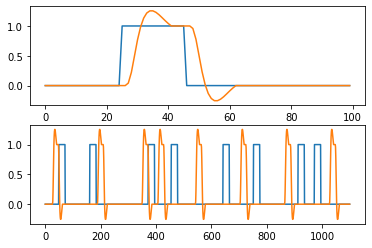

In [60]:
# plot the new EVs:
fig, a = plt.subplots(2, 1)
a[0].plot(parametric_stimulus_data['WPM_0050'][:100])
a[0].plot(data_wpm_0050[:100])

a[1].plot(parametric_stimulus_data['WPM_0350'])
a[1].plot(data_wpm_0050)

## Design Matrix

In [61]:
data_wpm = [data_wpm_0050, data_wpm_0350, data_wpm_0650, data_wpm_0950, data_wpm_1250]
mean_subtracted_data = [dt - np.mean(dt) for dt in data_wpm]
design_matrix = np.asarray(mean_subtracted_data +[np.ones_like(mean_subtracted_data[0])]).T

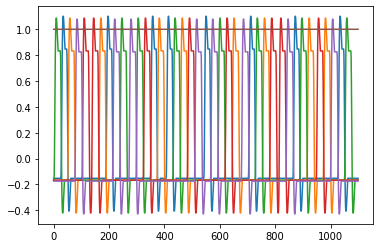

In [63]:
plt.plot(design_matrix)

## HRF Experiments

In [50]:
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

In [51]:
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude



In [52]:
hrf_models = [None, 'glover + derivative', 'glover + derivative + dispersion']

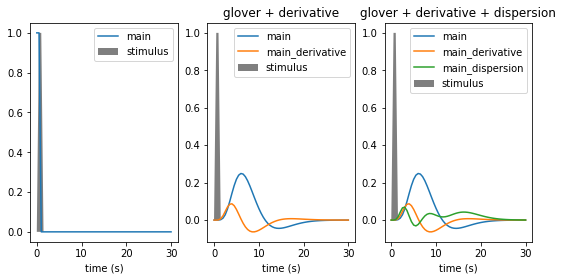

In [53]:
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
for i, hrf_model in enumerate(hrf_models):
    # obtain the signal of interest by convolution
    signal, name = compute_regressor(
        exp_condition, hrf_model, frame_times, con_id='main',
        oversampling=16)

    # plot this
    plt.subplot(1, 3, i + 1)
    plt.fill(frame_times, stim, 'k', alpha=.5, label='stimulus')
    for j in range(signal.shape[1]):
        plt.plot(frame_times, signal.T[j], label=name[j])
    plt.xlabel('time (s)')
    plt.legend(loc=1)
    plt.title(hrf_model)

# adjust the plot
plt.subplots_adjust(bottom=.12)
plt.show()

## continue GLM

In [64]:
from fsl_experiment_suite.glm import glm

In [66]:
mask_glm = np.sum(fmri_without_background**2,axis=0)>0

In [68]:
beta, t = glm(Y=fmri_without_background, X=design_matrix, mask = mask_glm)

In [71]:
t_fmri = masking.unmask(t, background_mask)
beta_fmri = masking.unmask(beta, background_mask)

In [72]:
t_fmri.shape

(91, 109, 91, 6)


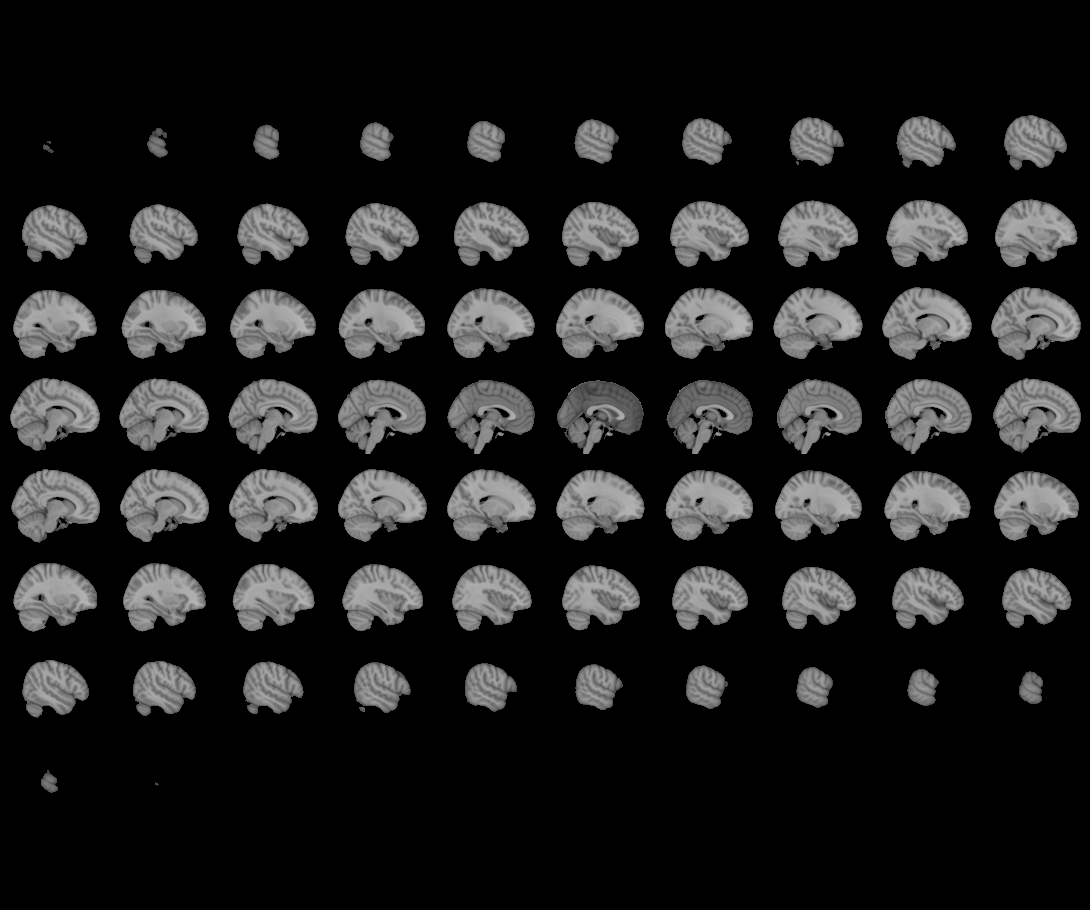
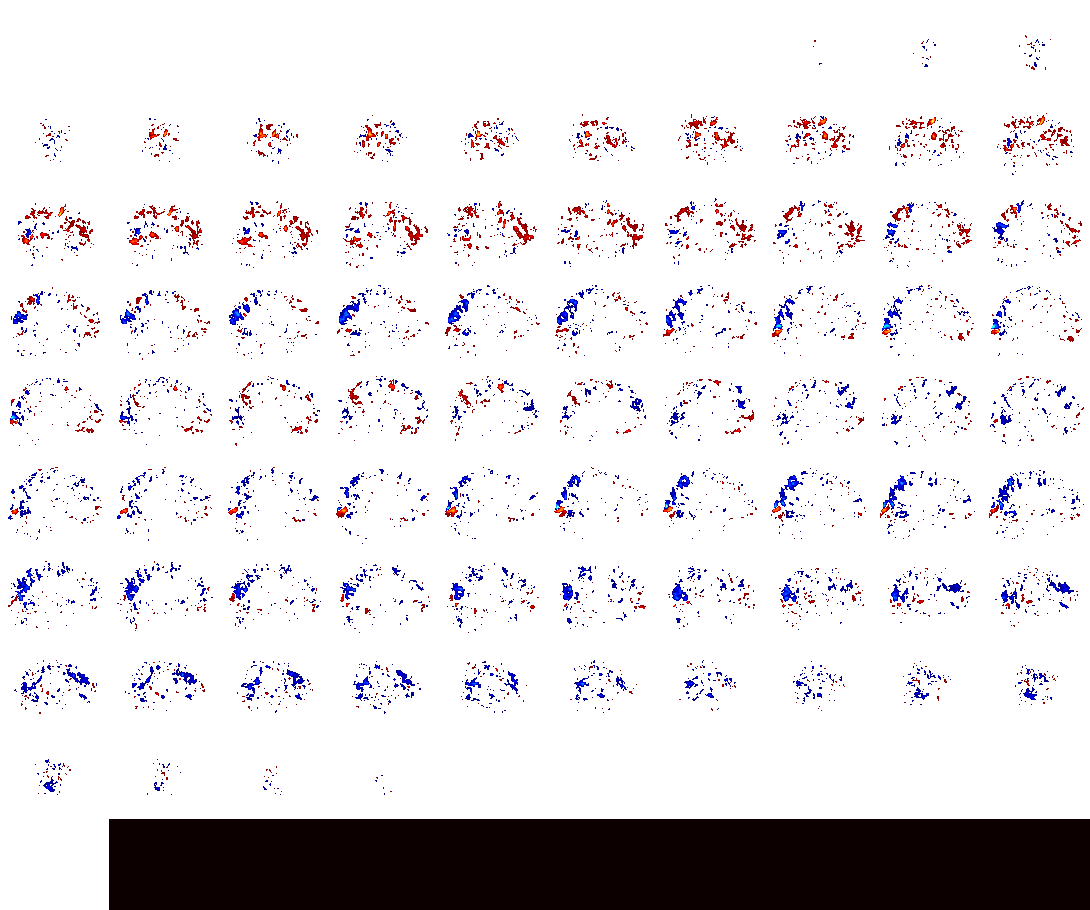

In [75]:
plotting.view_img(image.index_img(t_fmri, 0), threshold=2.5)


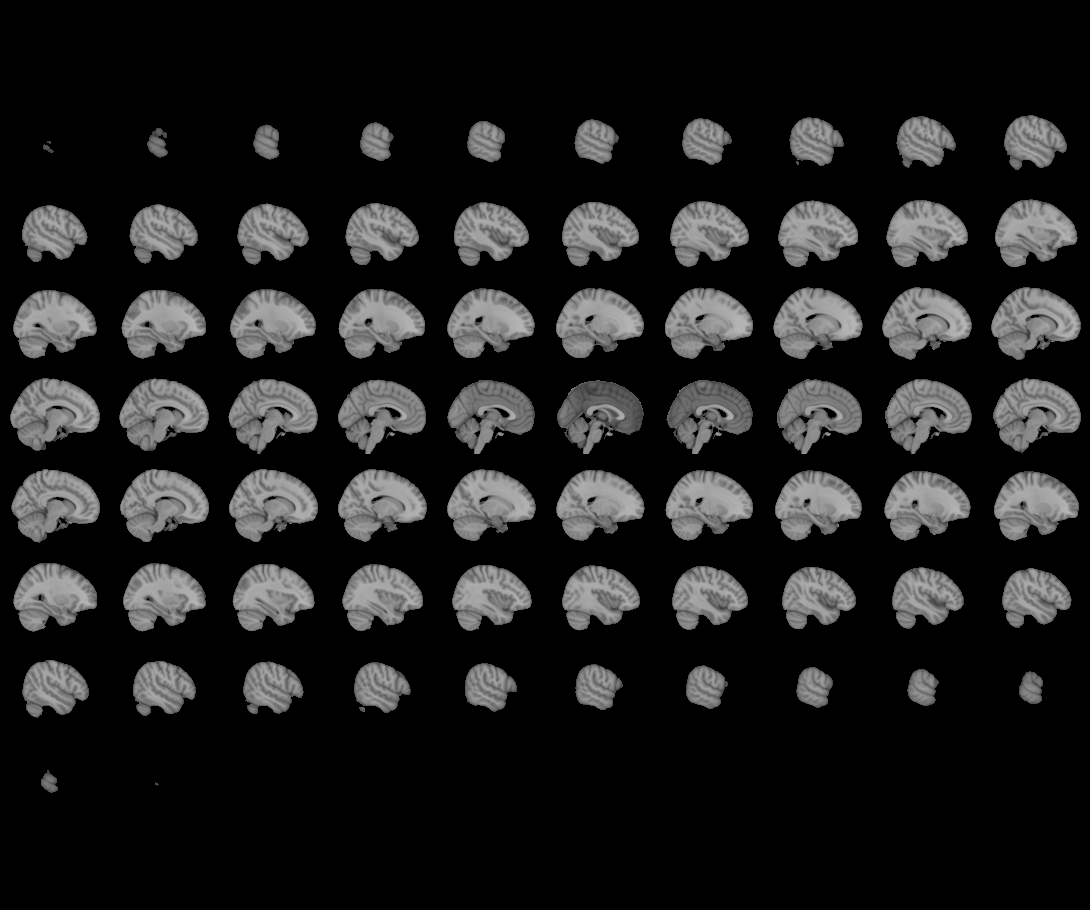
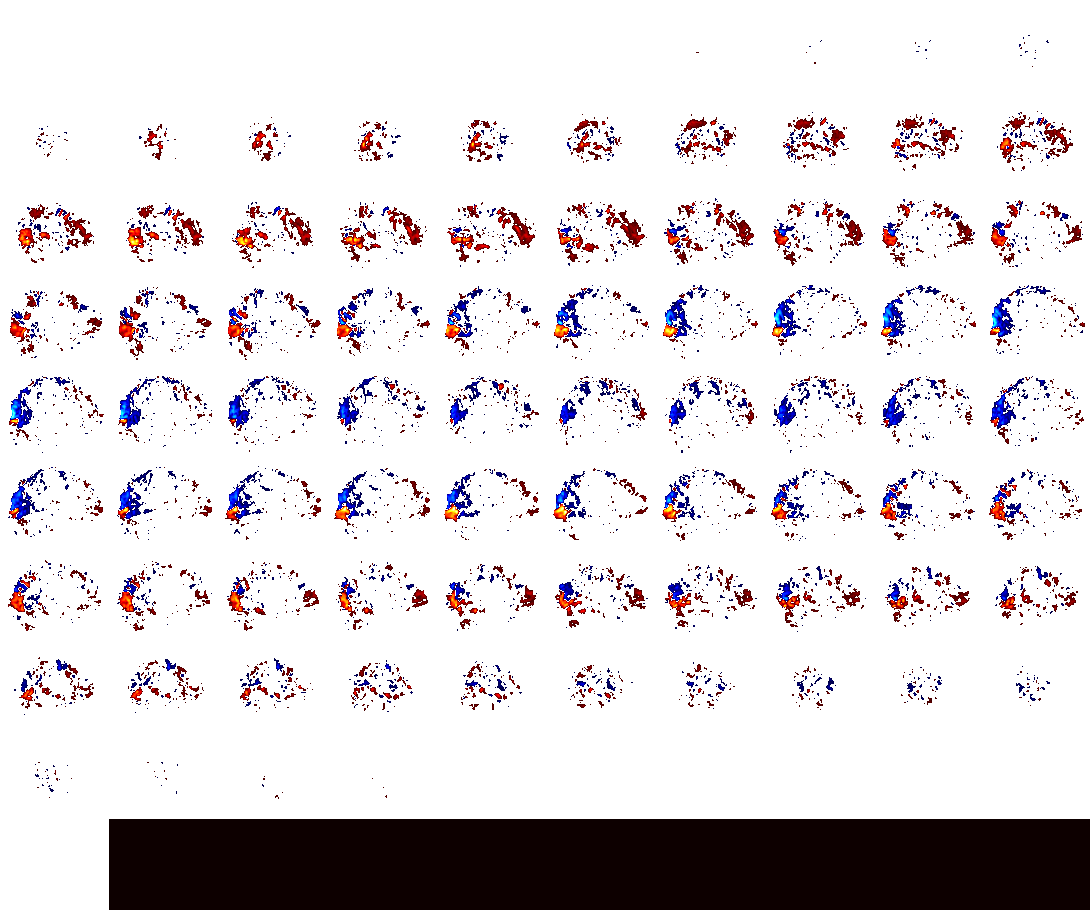

In [84]:
plotting.view_img(image.index_img(t_fmri, 2), threshold=2.5)

In [93]:
nilearn.image.index_img(fmri_img, [1:25]).shape

SyntaxError: invalid syntax (3069493304.py, line 1)


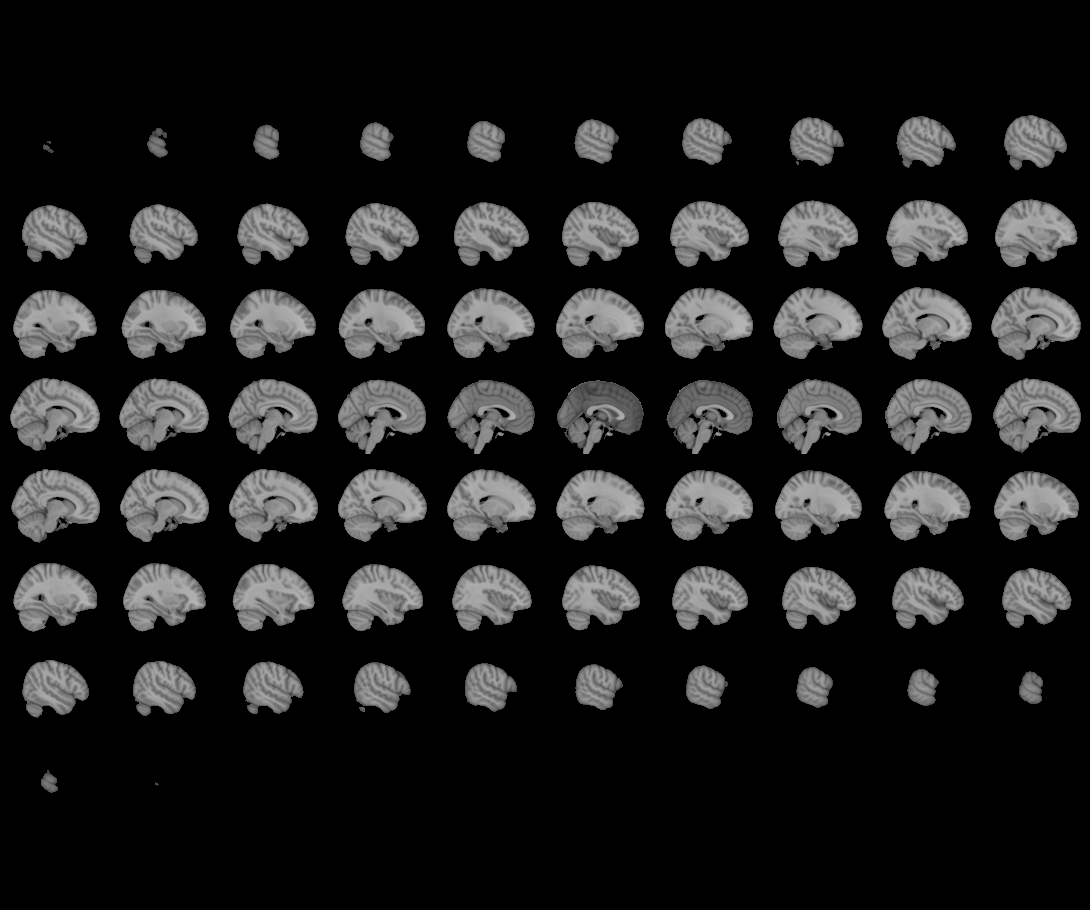
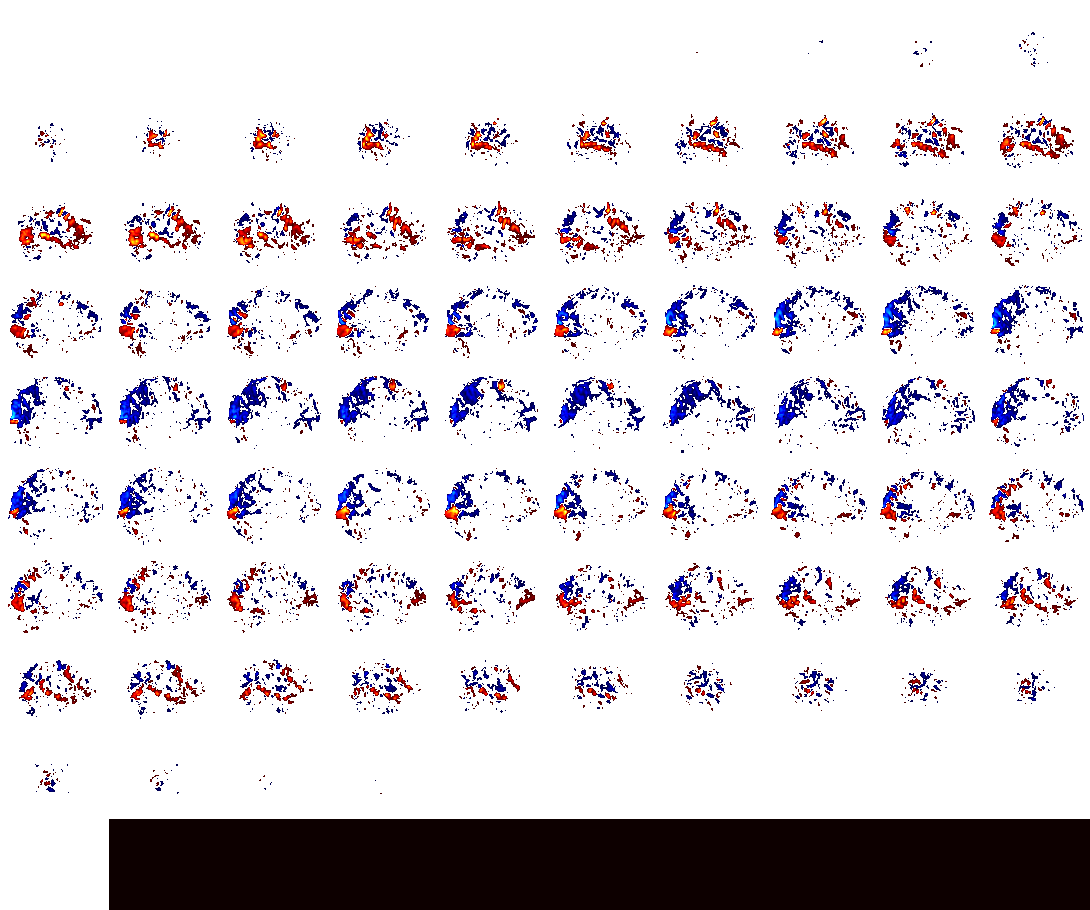

In [82]:
plotting.view_img(image.index_img(t_fmri, 4), threshold=2.5)

# Exploring Harvard-Oxford Atlas

In [77]:
from nilearn.datasets import fetch_atlas_harvard_oxford

In [86]:
atlas = fetch_atlas_harvard_oxford("cort-prob-2mm")

In [87]:
for i, label in enumerate(atlas.labels):
    print(f"Label {i}: {label}")

Label 0: Background
Label 1: Frontal Pole
Label 2: Insular Cortex
Label 3: Superior Frontal Gyrus
Label 4: Middle Frontal Gyrus
Label 5: Inferior Frontal Gyrus, pars triangularis
Label 6: Inferior Frontal Gyrus, pars opercularis
Label 7: Precentral Gyrus
Label 8: Temporal Pole
Label 9: Superior Temporal Gyrus, anterior division
Label 10: Superior Temporal Gyrus, posterior division
Label 11: Middle Temporal Gyrus, anterior division
Label 12: Middle Temporal Gyrus, posterior division
Label 13: Middle Temporal Gyrus, temporooccipital part
Label 14: Inferior Temporal Gyrus, anterior division
Label 15: Inferior Temporal Gyrus, posterior division
Label 16: Inferior Temporal Gyrus, temporooccipital part
Label 17: Postcentral Gyrus
Label 18: Superior Parietal Lobule
Label 19: Supramarginal Gyrus, anterior division
Label 20: Supramarginal Gyrus, posterior division
Label 21: Angular Gyrus
Label 22: Lateral Occipital Cortex, superior division
Label 23: Lateral Occipital Cortex, inferior division


In [85]:
atlas_map = nib.load(atlas.maps)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


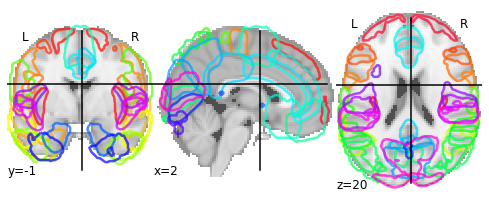

In [88]:
plot_prob_atlas(atlas_map)

In [ ]:
from ni